# Comparison between 2$\kappa$ and 2$T$ models

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
import mpmath as mp
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
def fkM(v):
    r_s = ( 1 + (v-u_s)**2/kappa_s/v_s**2 )**(-kappa_s)
    A_s = n_s/np.sqrt(np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    rf = n_f/np.sqrt(np.pi*v_f**2)*np.exp(-(v-u_f)**2/v_f**2)
    return A_s*r_s + rf

def fkK(v):
    r_s = ( 1 + (v-u_s)**2/kappa_s/v_s**2 )**(-kappa_s)
    r_f = ( 1 + (v-u_f)**2/kappa_f/v_f**2 )**(-kappa_f)
    A_s = n_s/np.sqrt(np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(np.pi*kappa_f)/v_f * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    return A_s*r_s+A_f*r_f

def fm(v):
    rc = n_c/np.sqrt(np.pi*v_c**2)*np.exp(-(v-u_c)**2/v_c**2)
    rh = n_h/np.sqrt(np.pi*v_h**2)*np.exp(-(v-u_h)**2/v_h**2)
    return rc+rh

def PDR_2KM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_fM**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]

def PDR_2KK(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_fK**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def PDR_2T(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_c = (wc / k - u_c) /v_c
    zeta_h = (wc / k - u_h) /v_h
    r = 1 + 1 / k**2 / l_c**2 * ( 1 + zeta_c*plasmapy.dispersion.plasma_dispersion_func(zeta_c) ) + 1 / k**2 / l_h**2 * ( 1 + zeta_h*plasmapy.dispersion.plasma_dispersion_func(zeta_h) )
    return [r.real,r.imag]

def PDR_ANAL(k):
    klc = 1+3*k**2*l_c**2+3*l_c**2/l_h**2
    klh = 1+3*k**2*l_h**2
    w_eaw = wp_c*np.sqrt(klc/(1+1/(k*l_h)**2))
    r_eaw = -np.sqrt(np.pi/8) * n_c/n_h * (klc)/(1+k**2*l_h**2)**2 *k*np.sqrt(T_h)
    return w_eaw,r_eaw

def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1,2*kappa+2,kappa+2,z))
    return fac*hyp

def Set2TParas():
    n_h = n-n_c
    wp_c = np.sqrt( n_c * q**2 )
    wp_h = np.sqrt( n_h * q**2 )
    T_c = 0.5*m*v_c**2
    T_h = 0.5*m*v_h**2
    l_c = np.sqrt(T_c/n_c)
    l_h = np.sqrt(T_h/n_h)
    u_h = a*v_c
    u_c = 0
    return n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h

def Set2KParas():
    n_f = n-n_s
    kappa_s = 1.5/(1-v_s**2/v_f**2)
    T_s = 0.5*m*kappa_s/(kappa_s-1.5)*v_s**2
    T_fM = 0.5*m*v_f**2
    T_fK = 0.5*m*kappa_f/(kappa_f-1.5)*v_f**2
    l_s = np.sqrt( T_s / n_s / q**2 ) # $\lambda_D^2$
    l_fM = np.sqrt( T_fM / n_f / q**2 ) # $\lambda_D^2$
    l_fK = np.sqrt( T_fK / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    u_f = a*v_s
    u_s = 0
    return n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s

def PrintParas():
    paras_table = PrettyTable(['a='+str(a),'n','T','kappa','wp','theta','lambda_D','u'])
    paras_table.add_row(['c',n_c,round(T_c,4),'inf',round(wp_c,4),round(v_c,4),round(l_c,4),round(u_c,4)])
    paras_table.add_row(['h ',n_h,round(T_h,4),'inf',round(wp_h,4),round(v_h,4),round(l_h,4),round(u_h,4)])
    paras_table.add_row(['s',n_s,round(T_s,4),round(kappa_s,4),round(wp_s,4),round(v_s,4),round(l_s,4),round(u_s,4)])
    paras_table.add_row(['fM',n_f,round(T_fM,4),'inf',round(wp_f,4),round(v_f,4),round(l_fM,4),round(u_f,4)])
    paras_table.add_row(['fK',n_f,round(T_fK,4),round(kappa_f,4),round(wp_f,4),round(v_f,4),round(l_fK,4),round(u_f,4)])
    print(paras_table)

In [4]:
n = 1
q = 1
m = 1

n_c = 0.1
v_c = 0.1
v_h = 1.
n_s = n_c
v_s = v_c
v_f = v_h
a = 10

kappa_f = 2

n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()
n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
PrintParas()

+------+-----+-------+--------+--------+-------+----------+-----+
| a=10 |  n  |   T   | kappa  |   wp   | theta | lambda_D |  u  |
+------+-----+-------+--------+--------+-------+----------+-----+
|  c   | 0.1 | 0.005 |  inf   | 0.3162 |  0.1  |  0.2236  |  0  |
|  h   | 0.9 |  0.5  |  inf   | 0.9487 |  1.0  |  0.7454  | 1.0 |
|  s   | 0.1 |  0.5  | 1.5152 | 0.3162 |  0.1  |  2.2361  |  0  |
|  fM  | 0.9 |  0.5  |  inf   | 0.9487 |  1.0  |  0.7454  | 1.0 |
|  fK  | 0.9 |  2.0  |   2    | 0.9487 |  1.0  |  1.4907  | 1.0 |
+------+-----+-------+--------+--------+-------+----------+-----+


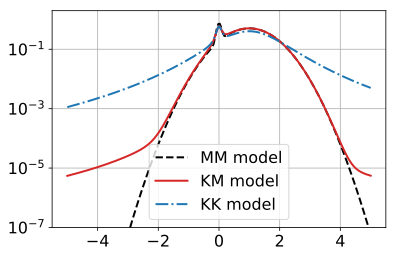

In [5]:
v_list = np.linspace(-5,5,num=200)
plt.plot(v_list,fm(v_list),'--',color='black',label='MM model')
plt.plot(v_list,fkM(v_list),color='tab:red',label='KM model')
plt.plot(v_list,fkK(v_list),'-.',color='tab:blue',label='KK model')
plt.legend()
plt.ylim(1e-7,2)
plt.yscale('log')
plt.grid()
plt.show()

In [6]:
k_list = np.linspace(0.1,2.0,num=200)
a_list = np.linspace(0,a,num=11)
w_2T_guess,r_2T_guess = PDR_ANAL(k_list[0])
w_2KM_guess = 0.009
r_2KM_guess = -0.011
w_2KK_guess = 0.009
r_2KK_guess = -0.011

In [7]:
for a_each in tqdm(a_list,position=0,leave=True):
    u_h = a_each * v_c
    u_f = a_each * v_s
    
    s2T = op.root(lambda w:PDR_2T(w,k_list[0]),[w_2T_guess,r_2T_guess])
    if s2T.success==True:
        w_2T_guess = s2T.x[0]
        r_2T_guess = s2T.x[1]
        
    s2KM = op.root(lambda w:PDR_2KM(w,k_list[0]),[w_2KM_guess,r_2KM_guess])
    if s2KM.success==True:
        w_2KM_guess = s2KM.x[0]
        r_2KM_guess = s2KM.x[1]
        
    s2KK = op.root(lambda w:PDR_2KK(w,k_list[0]),[w_2KK_guess,r_2KK_guess])
    if s2KK.success==True:
        w_2KK_guess = s2KK.x[0]
        r_2KK_guess = s2KK.x[1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.63it/s]


In [8]:
u_f = a*v_s
u_h = a*v_c

w_2T_list = []
r_2T_list = []
w_2KM_list = []
r_2KM_list = []
w_2KK_list = []
r_2KK_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s2T = op.root(lambda w:PDR_2T(w,k_each),[w_2T_guess,r_2T_guess])
    if s2T.success==True:
        w_2T_guess = s2T.x[0]
        r_2T_guess = s2T.x[1]
        w_2T_list.append(s2T.x[0])
        r_2T_list.append(s2T.x[1])
    else:
        w_2T_list.append(np.nan)
        r_2T_list.append(np.nan)
        
    s2KM = op.root(lambda w:PDR_2KM(w,k_each),[w_2KM_guess,r_2KM_guess])
    if s2KM.success==True:
        w_2KM_guess = s2KM.x[0]
        r_2KM_guess = s2KM.x[1]
        w_2KM_list.append(s2KM.x[0])
        r_2KM_list.append(s2KM.x[1])
    else:
        w_2KM_list.append(np.nan)
        r_2KM_list.append(np.nan)
        
    s2KK = op.root(lambda w:PDR_2KK(w,k_each),[w_2KK_guess,r_2KK_guess])
    if s2KK.success==True:
        w_2KK_guess = s2KK.x[0]
        r_2KK_guess = s2KK.x[1]
        w_2KK_list.append(s2KK.x[0])
        r_2KK_list.append(s2KK.x[1])
    else:
        w_2KK_list.append(np.nan)
        r_2KK_list.append(np.nan)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.07it/s]


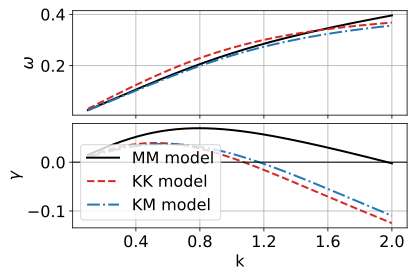

In [9]:
k_ticks = np.linspace(0,k_list[-1],num=6)
fig = plt.figure(figsize=(6,4))

ax1 = plt.subplot(211)
ax1.set_ylabel(r'$\omega$')
plt.xticks(k_ticks,[])
ax1.grid()

ax2 = plt.subplot(212)
plt.xticks(k_ticks)
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

ax1.plot(k_list,w_2T_list,'-',color='black')
ax1.plot(k_list,w_2KK_list,'--',color='tab:red')
ax1.plot(k_list,w_2KM_list,'-.',color='tab:blue')

ax2.plot(k_list,r_2T_list,'-',color='black',label='MM model')
ax2.plot(k_list,r_2KK_list,'--',color='tab:red',label='KK model')
ax2.plot(k_list,r_2KM_list,'-.',color='tab:blue',label='KM model')
ax2.axhline(0,color='black',linewidth=1)
plt.legend()

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./figs/revised/fig7.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

## unstable regime

## $n_s$ vs $a$

In [10]:
n_c = n_s = 0.01
v_c = v_s = 0.1
v_f = v_h = 1.0
a = 0
n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()

r2T_max_mat = []
r2KM_max_mat = []
r2KK_max_mat = []

w_2T_guess,r_2T_guess = PDR_ANAL(k_list[0])
w_2KM_guess = 0.008
r_2KM_guess = -0.007
w_2KK_guess = 0.008
r_2KK_guess = -0.007

n_list = np.linspace(n_s,0.9,num=10)
a_list = np.linspace(0,10,num=10)

w_2T_k0 = r_2T_k0 = 0.0
w_2T_a0 = r_2T_a0 = 0.0
w_2KK_k0 = r_2KK_k0 = 0.0
w_2KK_a0 = r_2KK_a0 = 0.0
w_2KM_k0 = r_2KM_k0 = 0.0
w_2KM_a0 = r_2KM_a0 = 0.0

In [11]:
for n_each in tqdm(n_list,position=0,leave=True):
    n_s = n_each
    n_c = n_each
    r2T_max_list = []
    r2KM_max_list = []
    r2KK_max_list = []
    for a_each in a_list:
        a = a_each
        n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
        r2T_list=np.array([])
        n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()
        r2KM_list=np.array([])
        r2KK_list=np.array([])
        for k_each in k_list:
            s2T = op.root(lambda w:PDR_2T(w,k_each),[w_2T_guess,r_2T_guess])
            if s2T.success==True:
                w_2T_guess = s2T.x[0]
                r_2T_guess = s2T.x[1]
                r2T_list = np.append(r2T_list,s2T.x[1])
                
            s2KM = op.root(lambda w:PDR_2KM(w,k_each),[w_2KM_guess,r_2KM_guess])
            if s2KM.success==True:
                w_2KM_guess = s2KM.x[0]
                r_2KM_guess = s2KM.x[1]
                r2KM_list = np.append(r2KM_list,s2KM.x[1])

            s2KK = op.root(lambda w:PDR_2KK(w,k_each),[w_2KK_guess,r_2KK_guess])
            if s2KK.success==True:
                w_2KK_guess = s2KK.x[0]
                r_2KK_guess = s2KK.x[1]
                r2KK_list = np.append(r2KK_list,s2KK.x[1])
                
            if k_each == k_list[0]:
                w_2T_k0 = w_2T_guess
                r_2T_k0 = r_2T_guess
                w_2KM_k0 = w_2KM_guess
                r_2KM_k0 = r_2KM_guess
                w_2KK_k0 = w_2KK_guess
                r_2KK_k0 = r_2KK_guess
                if a_each == a_list[0]:
                    w_2T_a0 = w_2T_k0
                    r_2T_a0 = r_2T_k0
                    w_2KM_a0 = w_2KM_k0
                    r_2KM_a0 = r_2KM_k0
                    w_2KK_a0 = w_2KK_k0
                    r_2KK_a0 = r_2KK_k0
        r2T_max_list.append(np.amax(r2T_list))
        r2KM_max_list.append(np.amax(r2KM_list))
        r2KK_max_list.append(np.amax(r2KK_list))
        w_2T_guess = w_2T_k0
        r_2T_guess = r_2T_k0
        w_2KM_guess = w_2KM_k0
        r_2KM_guess = r_2KM_k0
        w_2KK_guess = w_2KK_k0
        r_2KK_guess = r_2KK_k0
    r2T_max_mat.append(r2T_max_list)
    r2KM_max_mat.append(r2KM_max_list)
    r2KK_max_mat.append(r2KK_max_list)
    w_2T_guess = w_2T_a0
    r_2T_guess = r_2T_a0
    w_2KM_guess = w_2KM_a0
    r_2KM_guess = r_2KM_a0
    w_2KK_guess = w_2KK_a0
    r_2KK_guess = r_2KK_a0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:28:45<00:00, 532.58s/it]


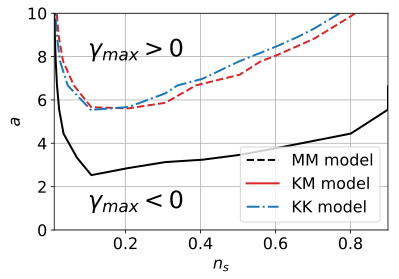

In [12]:
a_grid,n_s_grid=np.meshgrid(a_list,n_list)
plt.contour(n_s_grid,a_grid,r2KM_max_mat,levels=[-1,0,1],linestyles='--',colors='tab:red')
plt.contour(n_s_grid,a_grid,r2KK_max_mat,levels=[-1,0,1],linestyles='-.',colors='tab:blue')
plt.contour(n_s_grid,a_grid,r2T_max_mat,levels=[-1,0,1],linestyles='-',colors='black')
plt.plot([],[],'--',color='black',label='MM model')
plt.plot([],[],'-',color='tab:red',label='KM model')
plt.plot([],[],'-.',color='tab:blue',label='KK model')
plt.text(0.1,8,r'$\gamma_{max}>0$',fontsize=24)
plt.text(0.1,1,r'$\gamma_{max}<0$',fontsize=24)
plt.legend(loc=4)
plt.xlabel('$n_s$')
plt.ylabel('$a$')
plt.grid()
plt.show()

## Simulations

### simulation parameters

In [27]:
T = 1
n_s = 0.7
v_s = 0.1
v_f = 1.
a = 10

n_c = n_s
v_c = v_s
v_h = v_f

kappa_f = 2

n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()
n_h,wp_c,wp_h,l_c,l_h,u_c,u_h,T_c,T_h = Set2TParas()
PrintParas()

k = 1.0
L = 2*np.pi/k

vmax = 10 # 速度最大值
nx = 1001
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.02
max_steps  = 10000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1
d = 0.001

path = 'E:/代码/vlasov-es1d/data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

+------+---------------------+-------+--------+--------+-------+----------+-----+
| a=10 |          n          |   T   | kappa  |   wp   | theta | lambda_D |  u  |
+------+---------------------+-------+--------+--------+-------+----------+-----+
|  c   |         0.7         | 0.005 |  inf   | 0.8367 |  0.1  |  0.0845  |  0  |
|  h   | 0.30000000000000004 |  0.5  |  inf   | 0.5477 |  1.0  |  1.291   | 1.0 |
|  s   |         0.7         |  0.5  | 1.5152 | 0.8367 |  0.1  |  0.8452  |  0  |
|  fM  | 0.30000000000000004 |  0.5  |  inf   | 0.5477 |  1.0  |  1.291   | 1.0 |
|  fK  | 0.30000000000000004 |  2.0  |   2    | 0.5477 |  1.0  |  2.582   | 1.0 |
+------+---------------------+-------+--------+--------+-------+----------+-----+
2
limited time= 314.1592653589793
real time =  200.0


In [28]:
# 计算特定k的w,r
k_idx = int( (k-k_list[0])/(k_list[1]-k_list[0]) )
s1_k = op.root(lambda w:PDR_2KM(w,k),[w_2KM_list[k_idx],r_2KM_list[k_idx]])
s2_k = op.root(lambda w:PDR_2T(w,k),[w_2T_list[k_idx],r_2T_list[k_idx]])
s3_k = op.root(lambda w:PDR_2KK(w,k),[w_2KK_list[k_idx],r_2KK_list[k_idx]])
print(s1_k.success,s1_k.x)
print(s2_k.success,s2_k.x)
print(s3_k.success,s3_k.x)
w_2K = s3_k.x[0]
r_2K = s3_k.x[1]
w_2T = s2_k.x[0]
r_2T = s2_k.x[1]

True [0.71076068 0.02165006]
True [0.69726561 0.05955927]
True [0.74198476 0.01147555]


In [29]:
print('r_kw   = ',round(r_2K,6))
print('wr/2/pi = ',round(w_2K/2/np.pi,6))

r_kw   =  0.011476
wr/2/pi =  0.118091


### simulation results

In [30]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

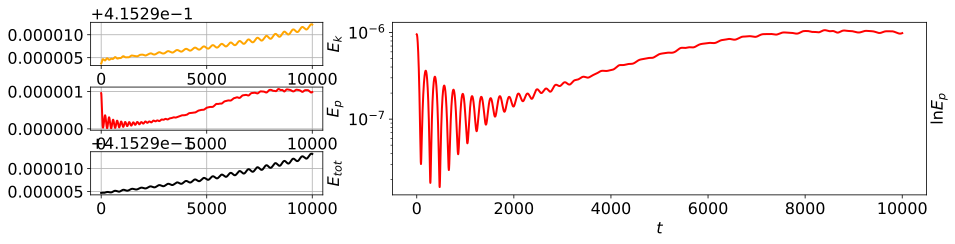

In [31]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [32]:
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

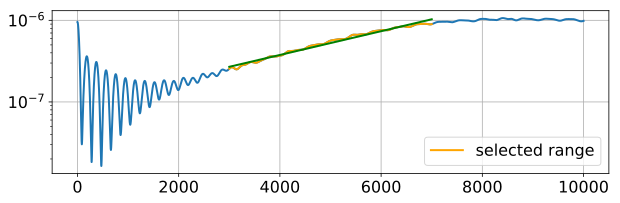

In [33]:
start = 3000
end = 7000

indexes, _ = scipy.signal.find_peaks(dataep, distance=1)
xep = indexes[12:16:1]
yep = np.log(dataep[xep])
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2

x = t[start:end]
y = dataep[start:end]
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(x, np.log(y)))
wi_sim = para[0]/dt/2

fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(x,y,color='orange',label='selected range')
theo = np.exp(line(para,x))
plt.plot(x,theo, '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [34]:
print(wi_sim)
print(r_2K)

0.008379852363722117
0.01147555457207186


In [35]:
wi_sim = para[0]/dt/2
wr0_err = abs(wr_sim-w_2K)/w_2K*100
wi0_err = abs((wi_sim-r_2K)/r_2K)*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory0',round(w_2K,6),round(r_2K,6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(wi_sim,6)])
com_table.add_row(['Error0(%)',round(wr0_err,6),round(abs(wi0_err),6)])
print(com_table)

+------------+-----------+-----------+
| EAW: k=1.0 |     wr    |     wi    |
+------------+-----------+-----------+
|  Theory0   |  0.741985 |  0.011476 |
| Simulation |  0.853694 |  0.00838  |
| Error0(%)  | 15.055417 | 26.976493 |
+------------+-----------+-----------+
